# TO DO: 
* Check in Unity for the axes orientation (our z values are negative, which only makes sense if the z direction in the scene is inverted) 

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import pickle
import os
import pandas as pd
import json
from itertools import compress
import math

from scipy import signal 

import glob

from DataManager import ParticipantData, MeasurementData
from Helpers import read_normalized_json_to_df, save_to_disk, load_from_disk, create_rolling_windows


In [2]:
def intersection(lst1, lst2): 
    tup1 = map(tuple, lst1) 
    tup2 = map(tuple, lst2)  
    return list(map(list, set(tup1).intersection(tup2))) 

def reject_outliers(data, m=2):
    # create index of data
    index = list(data.index)
    # check where to remove outliers with 2 sigma distance
    outlier_bool = abs(data - np.mean(data)) < m * np.std(data)
    
    # apply to index and data and return
    return data[outlier_bool], list(compress(index, outlier_bool))

def anglebetween(v1, v2):
    v1Norm = v1/np.linalg.norm(v1)
    v2Norm = v2/np.linalg.norm(v2)
    Dot = np.dot(v1Norm, v2Norm)
    angle = math.degrees(np.arccos(Dot))
    
    return angle


def eye_outlier_removal(pos_x, pos_y, pos_z, dir_x, dir_y, dir_z, m=1.5):
    
    # preparation
    outlier_df = pd.DataFrame()
    info_df = pd.DataFrame(columns=['Cluster', 'Length', 'Data Prop (%)'])
    pos_x = pos_x.copy()
    pos_y = pos_y.copy()
    pos_z = pos_z.copy()
    dir_x = dir_x.copy()
    dir_y = dir_y.copy()
    dir_z = dir_z.copy()
    
    # check where to remove outliers with m * sigma distance
    outlier_bool = abs(pos_x - np.mean(pos_x)) > m * np.std(pos_x)
    # get outlier indices 
    outlier_df['outlier_index'] = pos_x[outlier_bool].index
    # check for sample clusters
    outlier_df['clusters'] = (outlier_df['outlier_index']-1 != outlier_df['outlier_index'].shift()).cumsum()

    for cluster in range(1, outlier_df.clusters.max()+1):

        min_c = np.min(outlier_df.outlier_index[outlier_df.clusters == cluster])
        max_c = np.max(outlier_df.outlier_index[outlier_df.clusters == cluster])
 
        # check the min edge case 
        if min_c == 0:
            pos_x[min_c:max_c+1] = (pos_x[min_c] + pos_x[max_c+2])/2
            pos_y[min_c:max_c+1] = (pos_y[min_c] + pos_y[max_c+2])/2
            pos_z[min_c:max_c+1] = (pos_z[min_c] + pos_z[max_c+2])/2
            dir_x[min_c:max_c+1] = (dir_x[min_c] + dir_x[max_c+2])/2
            dir_y[min_c:max_c+1] = (dir_y[min_c] + dir_y[max_c+2])/2
            dir_z[min_c:max_c+1] = (dir_z[min_c] + dir_z[max_c+2])/2
            
        # check the max edge case
        elif max_c == len(pos_x):
            pos_x[min_c:max_c+1] = (pos_x[min_c-1] + pos_x[max_c+1])/2
            pos_y[min_c:max_c+1] = (pos_y[min_c-1] + pos_y[max_c+1])/2 
            pos_z[min_c:max_c+1] = (pos_z[min_c-1] + pos_z[max_c+1])/2 
            dir_x[min_c:max_c+1] = (dir_x[min_c-1] + dir_x[max_c+1])/2
            dir_y[min_c:max_c+1] = (dir_y[min_c-1] + dir_y[max_c+1])/2 
            dir_z[min_c:max_c+1] = (dir_z[min_c-1] + dir_z[max_c+1])/2 
        # all other cases
        elif (max_c-min_c)<=21:
            pos_x[min_c:max_c+1] = (pos_x[min_c-1] + pos_x[max_c+2])/2
            pos_y[min_c:max_c+1] = (pos_y[min_c-1] + pos_y[max_c+2])/2
            pos_z[min_c:max_c+1] = (pos_z[min_c-1] + pos_z[max_c+2])/2
            dir_x[min_c:max_c+1] = (dir_x[min_c-1] + dir_x[max_c+2])/2
            dir_y[min_c:max_c+1] = (dir_y[min_c-1] + dir_y[max_c+2])/2
            dir_z[min_c:max_c+1] = (dir_z[min_c-1] + dir_z[max_c+2])/2

        else:
            pass
        
        info_df.loc[cluster, 'Cluster'] = cluster
        info_df.loc[cluster, 'Length'] = max_c - min_c
        info_df.loc[cluster, 'Data Prop (%)'] = (max_c - min_c)/len(pos_x)*100

    return pos_x, pos_y, pos_z, dir_x, dir_y, dir_z, info_df, outlier_df


In [3]:
reference_data_all_failed_save_path = "./post_recorded_reference_data/reference_dict_all.pickle"
REFERENCE_DATA_ALL_EVENTS_FAILED = load_from_disk(reference_data_all_failed_save_path)

correlation_dict_path = "./post_recorded_reference_data/corr_dict.pickle"
CORRELATION_DICT = load_from_disk(correlation_dict_path)

# Load data

In [4]:
# global location variable 
GLOBAL_AREA = 'Westbrueck' 
GLOBAL_SEGMENT = 0
GLOBAL_SINGLE_PARTICIPANT = '0bc17d704fec4a9eb892d905fc2e5da9'

In [5]:
verbose = False

eyes_paths  = ["./data/EyeTracking/"]
input_paths = ["./data/Input/"]
calib_paths = ["./data/ParticipantCalibrationData/"]
scene_paths = ["./data/SceneData/"]

measurement1 = MeasurementData(eyes_paths,input_paths,calib_paths,scene_paths,verbose)


ParticipantData: Initialising participant 0bc17d704fec4a9eb892d905fc2e5da9.
ParticipantData: Loaded data (bootstrapped) for participant 0bc17d704fec4a9eb892d905fc2e5da9.
ParticipantData: Initialising participant 0d0d7bd79b1a48d4ad5e757cdbfc15c9.
ParticipantData: Loaded data (bootstrapped) for participant 0d0d7bd79b1a48d4ad5e757cdbfc15c9.


In [6]:
measurement1.apply_reference_data(REFERENCE_DATA_ALL_EVENTS_FAILED)

MeasurementData: Applying reference data to all participants...
MeasurementData: Done applying reference data to all participants.


In [7]:
print("Available participants: \n" + str(measurement1.get_participant_list()))
print()

Available participants: 
['0bc17d704fec4a9eb892d905fc2e5da9', '0d0d7bd79b1a48d4ad5e757cdbfc15c9']



# Extract participant data

In [8]:
### Reference data applied 

# Extract data of one participant, of one area, of one segment 
participant_exclusion_list = [p for p in measurement1.get_participant_list() if p != GLOBAL_SINGLE_PARTICIPANT]
one_participant_single_segment = measurement1.get_data(use_vanilla=False, filter_data=True, \
                 filter_by_corr_coeff_dict=CORRELATION_DICT, corr_coeff_threshold=0.95, \
                 exclude_participants=participant_exclusion_list)
one_participant_single_segment = one_participant_single_segment[GLOBAL_SINGLE_PARTICIPANT][GLOBAL_AREA][GLOBAL_SEGMENT] 

# Average data over multiple sessions per segment
average_over_all_participants = measurement1.get_data(use_vanilla = False, filter_data=True, filter_by_corr_coeff_dict=CORRELATION_DICT, corr_coeff_threshold=0.95, exclude_participants=[])
average_over_all_participants = measurement1.average_data(average_over_all_participants)
average_over_all_participants_single_segment = average_over_all_participants[GLOBAL_AREA][GLOBAL_SEGMENT] 


/Users/stefan/opt/anaconda3/envs/Body2Eye/lib/python3.8/site-packages/pandas/core/computation/expressions.py:204: UserWarning: evaluating in Python space because the '+' operator is not supported by numexpr for the bool dtype, use '|' instead
  warnings.warn(


In [9]:
### No reference data applied 

# Extract data of one participant, of one area, of one segment without ref data applied 
participant_exclusion_list = [p for p in measurement1.get_participant_list() if p != GLOBAL_SINGLE_PARTICIPANT]
one_participant_single_segment_no_ref_applied = measurement1.get_data(use_vanilla=True, filter_data=True, \
                 filter_by_corr_coeff_dict=CORRELATION_DICT, corr_coeff_threshold=0.95, \
                 exclude_participants=participant_exclusion_list)
one_participant_single_segment_no_ref_applied = \
    one_participant_single_segment_no_ref_applied[GLOBAL_SINGLE_PARTICIPANT][GLOBAL_AREA][GLOBAL_SEGMENT]

# Extract reference data for one area, one segment 
ref_data_one_participant_single_segment = REFERENCE_DATA_ALL_EVENTS_FAILED[GLOBAL_AREA][GLOBAL_SEGMENT]  


# Investigating outliers in vanilla data

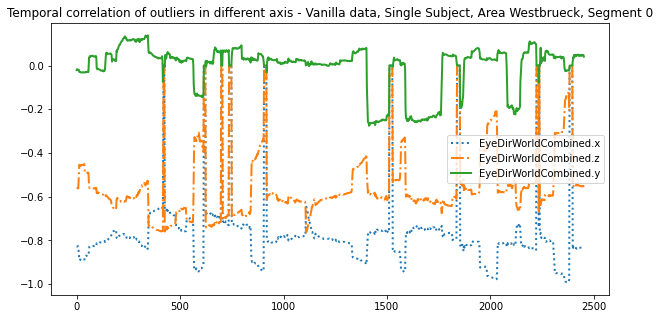

In [10]:
plt.figure(figsize=(10,5))
plt.plot(one_participant_single_segment_no_ref_applied['EyeDirWorldCombined.x'], linewidth=2, linestyle=':')
plt.plot(one_participant_single_segment_no_ref_applied['EyeDirWorldCombined.z'], linewidth=2, linestyle='-.')
plt.plot(one_participant_single_segment_no_ref_applied['EyeDirWorldCombined.y'], linewidth=2)

plt.title("Temporal correlation of outliers in different axis - Vanilla data, Single Subject, Area " + GLOBAL_AREA + ", Segment " + str(GLOBAL_SEGMENT))
plt.legend(['EyeDirWorldCombined.x', 'EyeDirWorldCombined.z', 'EyeDirWorldCombined.y'])
plt.show()

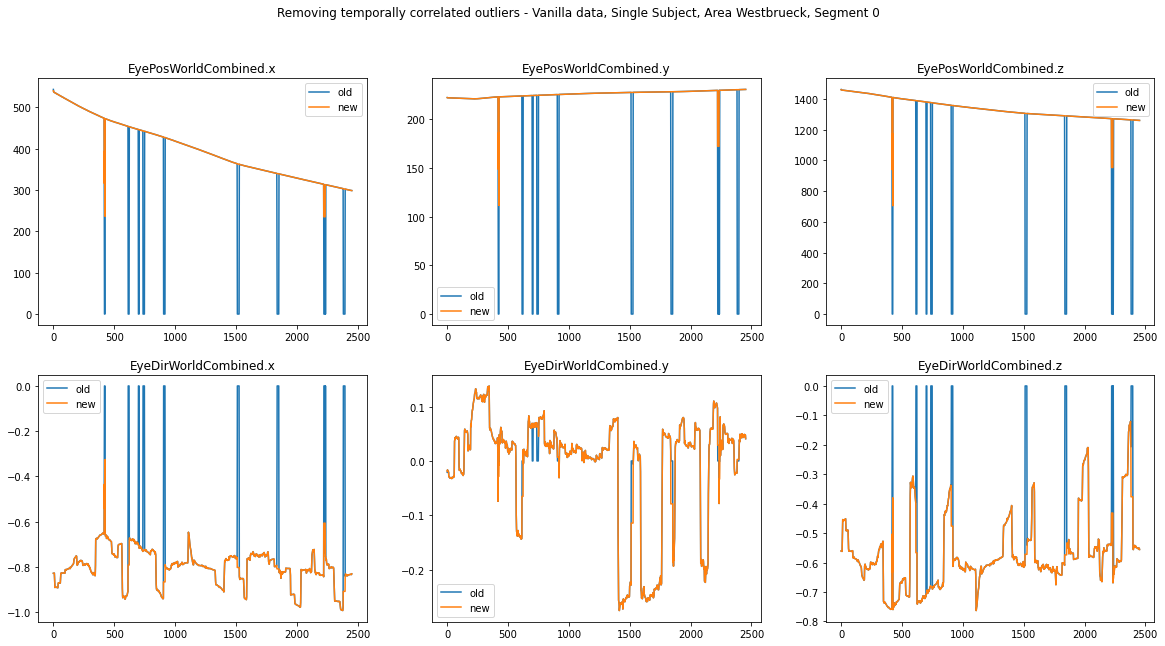

In [11]:
old_pos_x = one_participant_single_segment_no_ref_applied['EyePosWorldCombined.x']
old_pos_y = one_participant_single_segment_no_ref_applied['EyePosWorldCombined.y']
old_pos_z = one_participant_single_segment_no_ref_applied['EyePosWorldCombined.z']

old_dir_x = one_participant_single_segment_no_ref_applied['EyeDirWorldCombined.x']
old_dir_y = one_participant_single_segment_no_ref_applied['EyeDirWorldCombined.y']
old_dir_z = one_participant_single_segment_no_ref_applied['EyeDirWorldCombined.z']

pos_x, pos_y, pos_z, dir_x, dir_y, dir_z, info, outliers = \
    eye_outlier_removal(old_pos_x, old_pos_y, old_pos_z, old_dir_x, old_dir_y, old_dir_z)


plt.figure(figsize=(20,10))

plt.subplot(2,3,1)
plt.plot(old_pos_x)
plt.plot(pos_x)
plt.legend(["old","new"])
plt.title('EyePosWorldCombined.x')

plt.subplot(2,3,2)
plt.plot(old_pos_y)
plt.plot(pos_y)
plt.legend(["old","new"])
plt.title('EyePosWorldCombined.y')

plt.subplot(2,3,3)
plt.plot(old_pos_z)
plt.plot(pos_z)
plt.legend(["old","new"])
plt.title('EyePosWorldCombined.z')

plt.subplot(2,3,4)
plt.plot(old_dir_x)
plt.plot(dir_x)
plt.legend(["old","new"])
plt.title('EyeDirWorldCombined.x')

plt.subplot(2,3,5)
plt.plot(old_dir_y)
plt.plot(dir_y)
plt.legend(["old","new"])
plt.title('EyeDirWorldCombined.y')

plt.subplot(2,3,6)
plt.plot(old_dir_z)
plt.plot(dir_z)
plt.legend(["old","new"])
plt.title('EyeDirWorldCombined.z')

plt.suptitle("Removing temporally correlated outliers - Vanilla data, Single Subject, Area " + GLOBAL_AREA + ", Segment " + str(GLOBAL_SEGMENT))

plt.show()

# Comparing vanilla & reference data applied & reference data

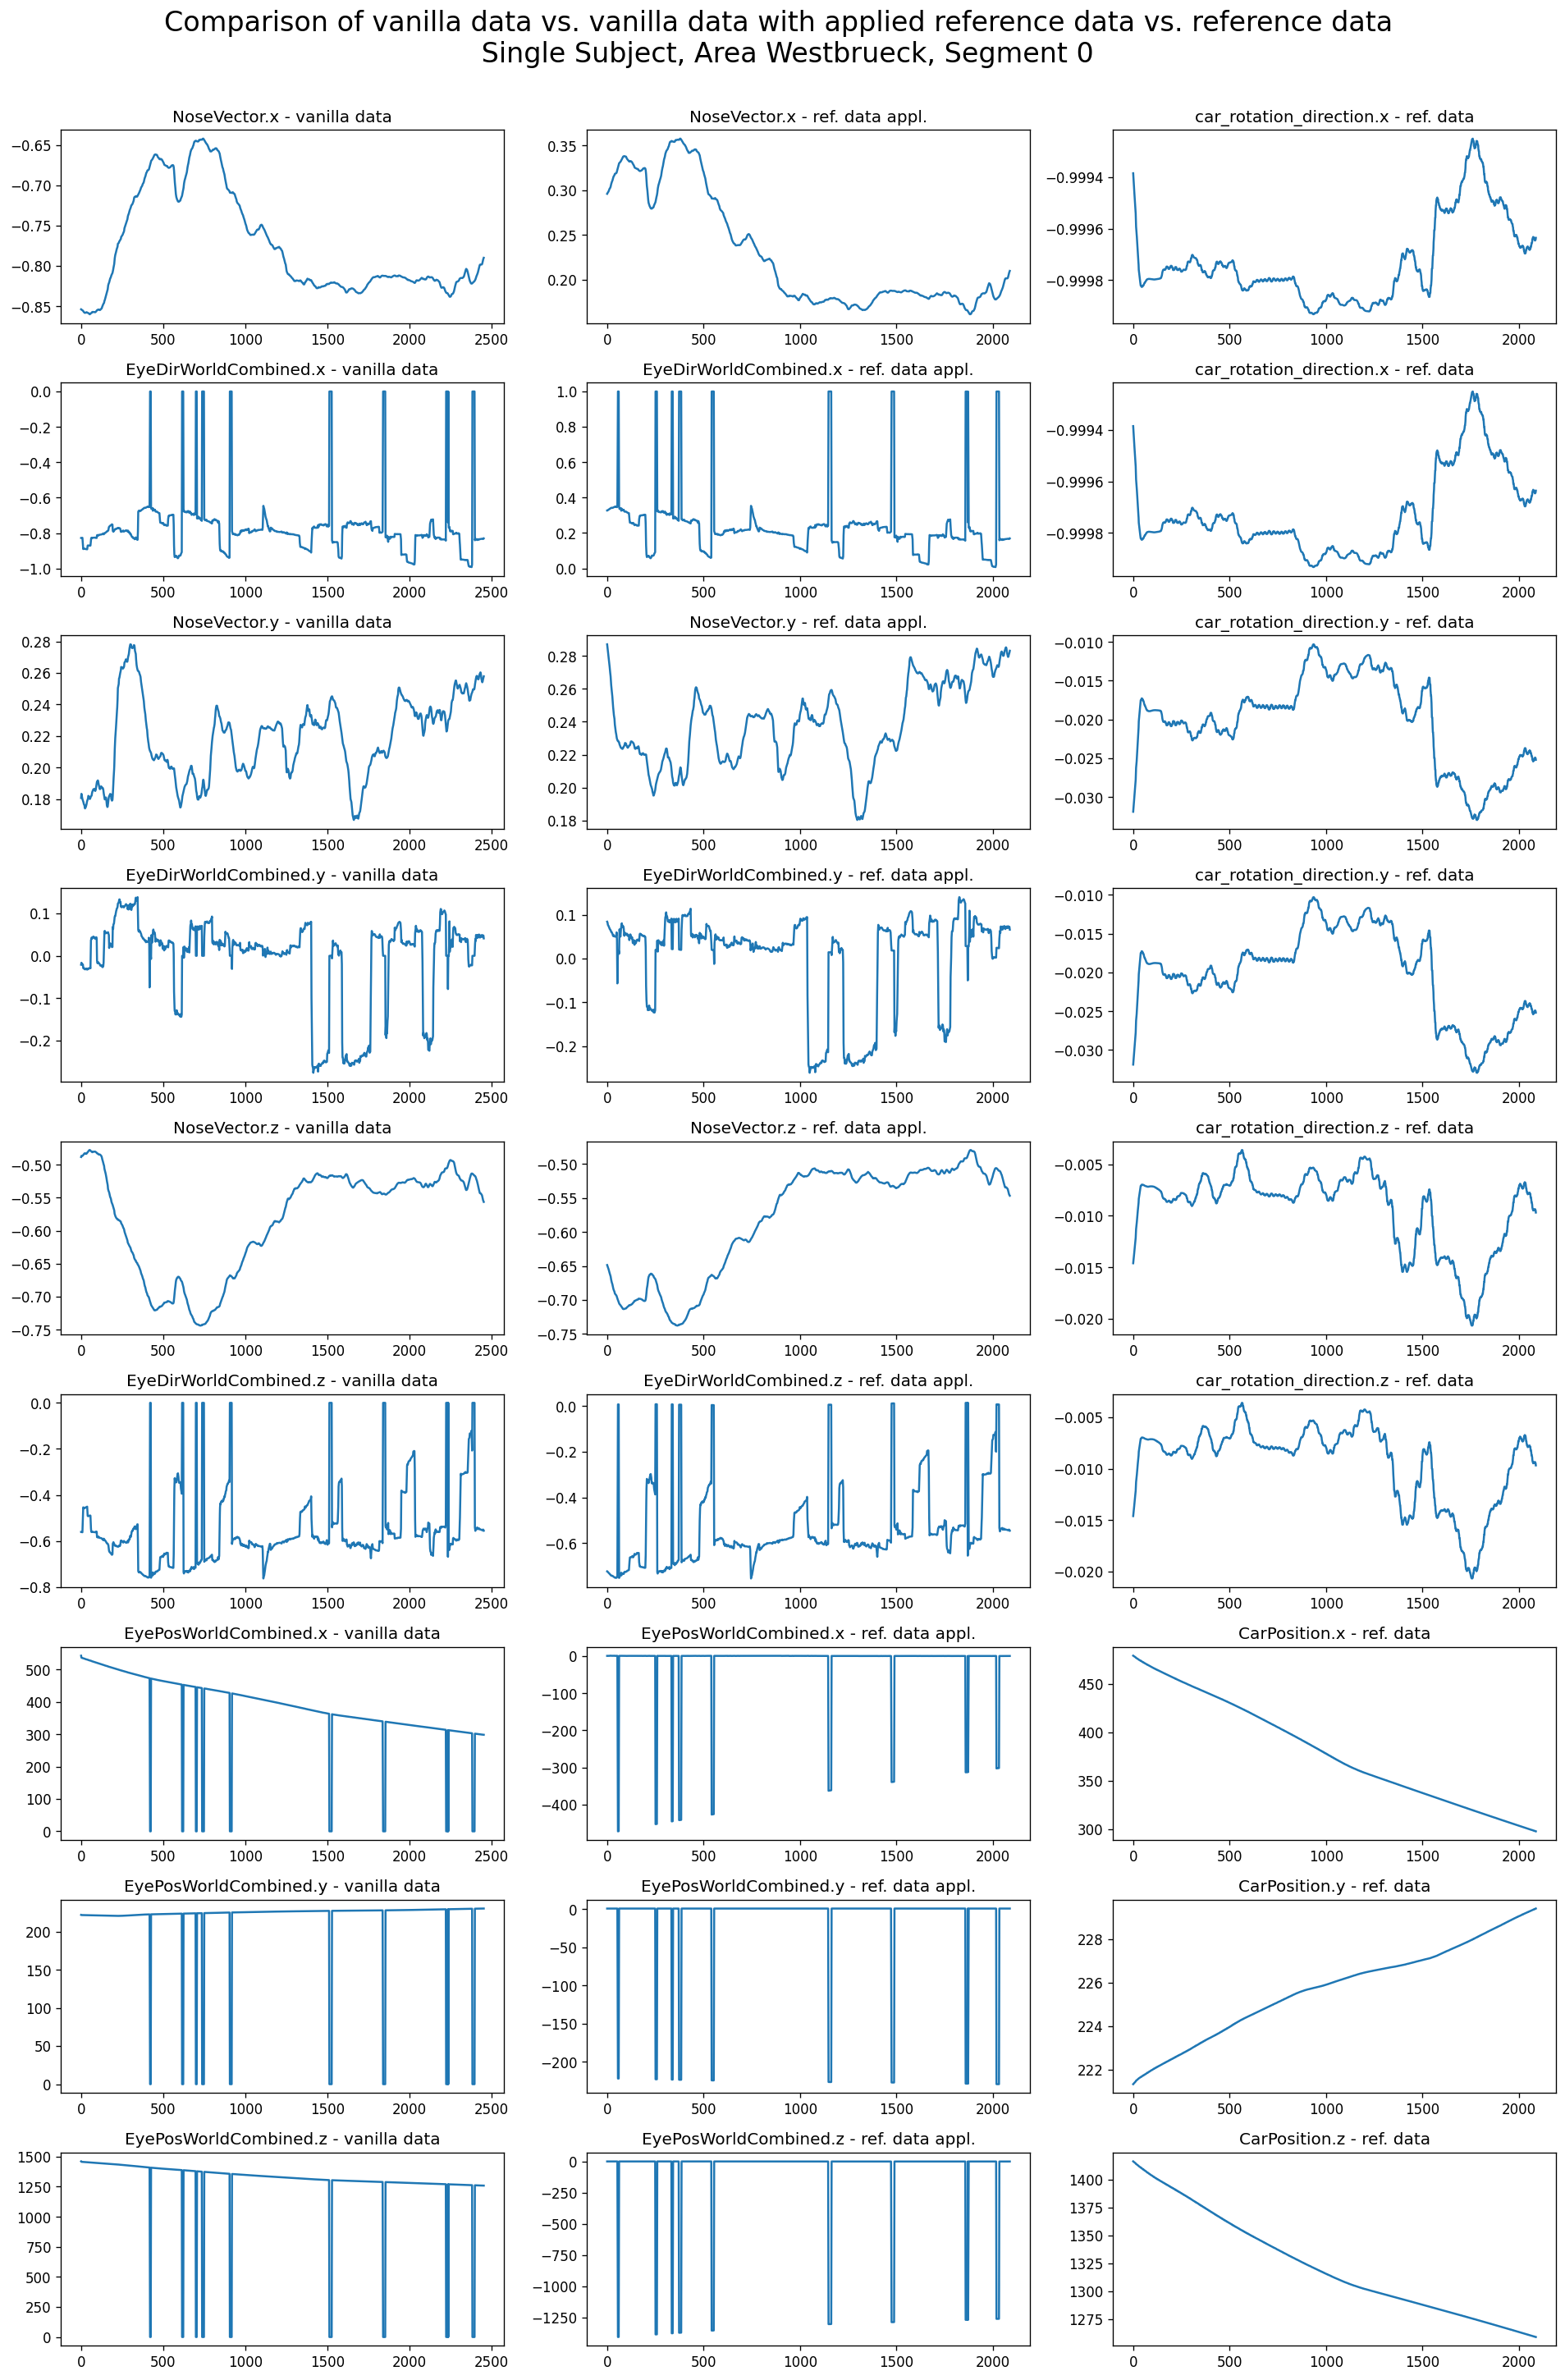

In [12]:
# Names of data columns to plot 
names_x = ["NoseVector.x","NoseVector.x",'car_rotation_direction.x',"EyeDirWorldCombined.x","EyeDirWorldCombined.x",'car_rotation_direction.x', \
           "NoseVector.y","NoseVector.y",'car_rotation_direction.y',"EyeDirWorldCombined.y","EyeDirWorldCombined.y",'car_rotation_direction.y', \
           "NoseVector.z","NoseVector.z",'car_rotation_direction.z',"EyeDirWorldCombined.z","EyeDirWorldCombined.z",'car_rotation_direction.z', \
           'EyePosWorldCombined.x','EyePosWorldCombined.x','CarPosition.x', \
           'EyePosWorldCombined.y','EyePosWorldCombined.y','CarPosition.y', \
           'EyePosWorldCombined.z','EyePosWorldCombined.z','CarPosition.z']

# plot comparison 
fig, ax = plt.subplots(nrows=9, ncols=3, figsize=(16,24), dpi=120)

for idx, row in enumerate(ax.reshape(-1)):
    
    # First column: Vanilla data 
    if idx % 3 == 0:
        
        x = one_participant_single_segment_no_ref_applied[names_x[idx]]
        row.plot(x)
        row.set_title(names_x[idx] + " - vanilla data")
        
    # Second column: Vanilla + reference data applied 
    elif idx % 3 == 1:
        
        x = one_participant_single_segment[names_x[idx]]
        row.plot(x)
        row.set_title(names_x[idx] + " - ref. data appl.")
    
    # Third column: Reference data
    elif idx % 3 == 2:
        
        x = ref_data_one_participant_single_segment[names_x[idx]] 
        row.plot(x)
        row.set_title(names_x[idx] + " - ref. data")


fig.suptitle("Comparison of vanilla data vs. vanilla data with applied reference data vs. reference data \n Single Subject, Area " + GLOBAL_AREA + ", Segment " + str(GLOBAL_SEGMENT),fontsize=20, y=1.005)
    
fig.tight_layout() 
plt.show()

# Checking for data similarity (Nose to Eye)
* X - Sanity:
    * always positive, i.e. subjects look towards the right
    * Makes sense since subjects sit on left car seat and look at central information aways from steering wheel
* Y - Sanity:
    * NoseY is always positive, i.e. head slightly raised, but eyes are level 
    * Could be VR effect due to the HMD weight
* Z - Sanity:
    * Always negative
    * Hypothesis: Car drives in negative z direction in the scene 

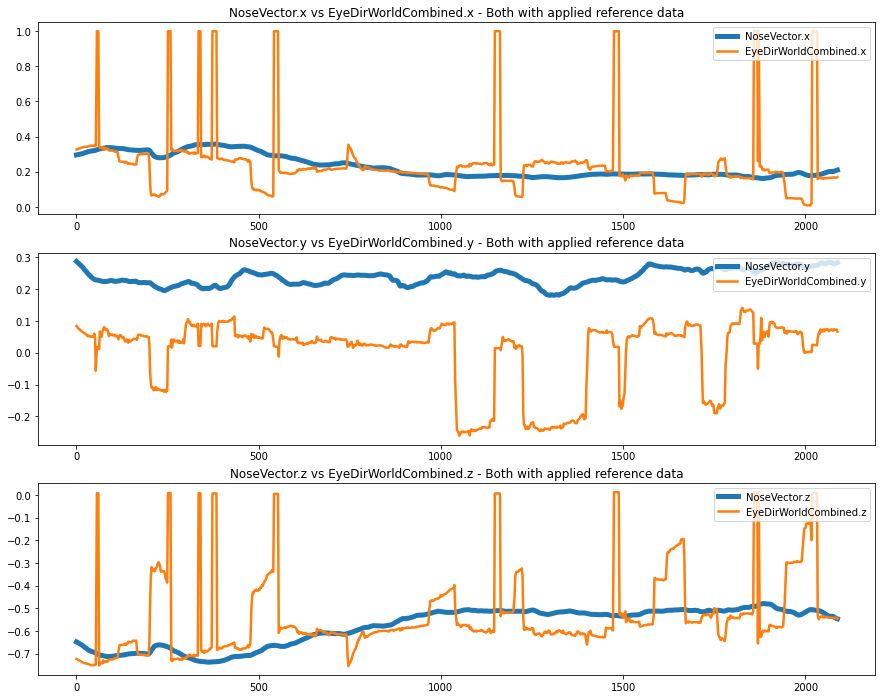

In [13]:
# X
nose_x= one_participant_single_segment['NoseVector.x'] 
eye_x = one_participant_single_segment['EyeDirWorldCombined.x'] 

# Y
nose_y = one_participant_single_segment['NoseVector.y']
eye_y = one_participant_single_segment['EyeDirWorldCombined.y']

# Z
nose_z = one_participant_single_segment['NoseVector.z']
eye_z = one_participant_single_segment['EyeDirWorldCombined.z']

# Plot 
plt.figure(figsize=(15,12))
plt.subplot(3,1,1)
plt.title('NoseVector.x vs EyeDirWorldCombined.x - Both with applied reference data')
plt.plot(nose_x, linewidth=5, label='NoseVector.x')
plt.plot(eye_x, linewidth=2.5, label='EyeDirWorldCombined.x')
plt.legend(loc="upper right")

plt.subplot(3,1,2)
plt.title('NoseVector.y vs EyeDirWorldCombined.y - Both with applied reference data')
plt.plot(nose_y, linewidth=5,label='NoseVector.y')
plt.plot(eye_y, linewidth=2.5, label='EyeDirWorldCombined.y')
plt.legend(loc="upper right")

plt.subplot(3,1,3)
plt.title('NoseVector.z vs EyeDirWorldCombined.z - Both with applied reference data')
plt.plot(nose_z, linewidth=5, label='NoseVector.z')
plt.plot(eye_z, linewidth=2.5, label='EyeDirWorldCombined.z')
plt.legend(loc="upper right")

plt.show()

# Power Spectral Density Analysis
Using Welch's method

In [14]:
def plot_power_spectral_densities(segment_data,names_x,plt_title,fig_size,nrows,ncols,x_lim=-1,y_lim=-1):
    
    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=fig_size, dpi=120)
    
    for idx, row in enumerate(ax.reshape(-1)):
        x = segment_data[names_x[idx]]
        f, pxx_den = signal.welch(x,fs=(1/0.01),nperseg=2048)
        row.semilogy(f, pxx_den)
        row.set_xlabel('Frequency [Hz]')
        row.set_ylabel('PSD [degree**2/Hz]')
        if x_lim > 0:
            row.set_xlim(0,x_lim)
        if y_lim > 0:
            row.set_ylim(0,y_lim)
        row.set_title(names_x[idx])

    fig.suptitle(plt_title, y=1.005)
    fig.tight_layout()
    plt.show()


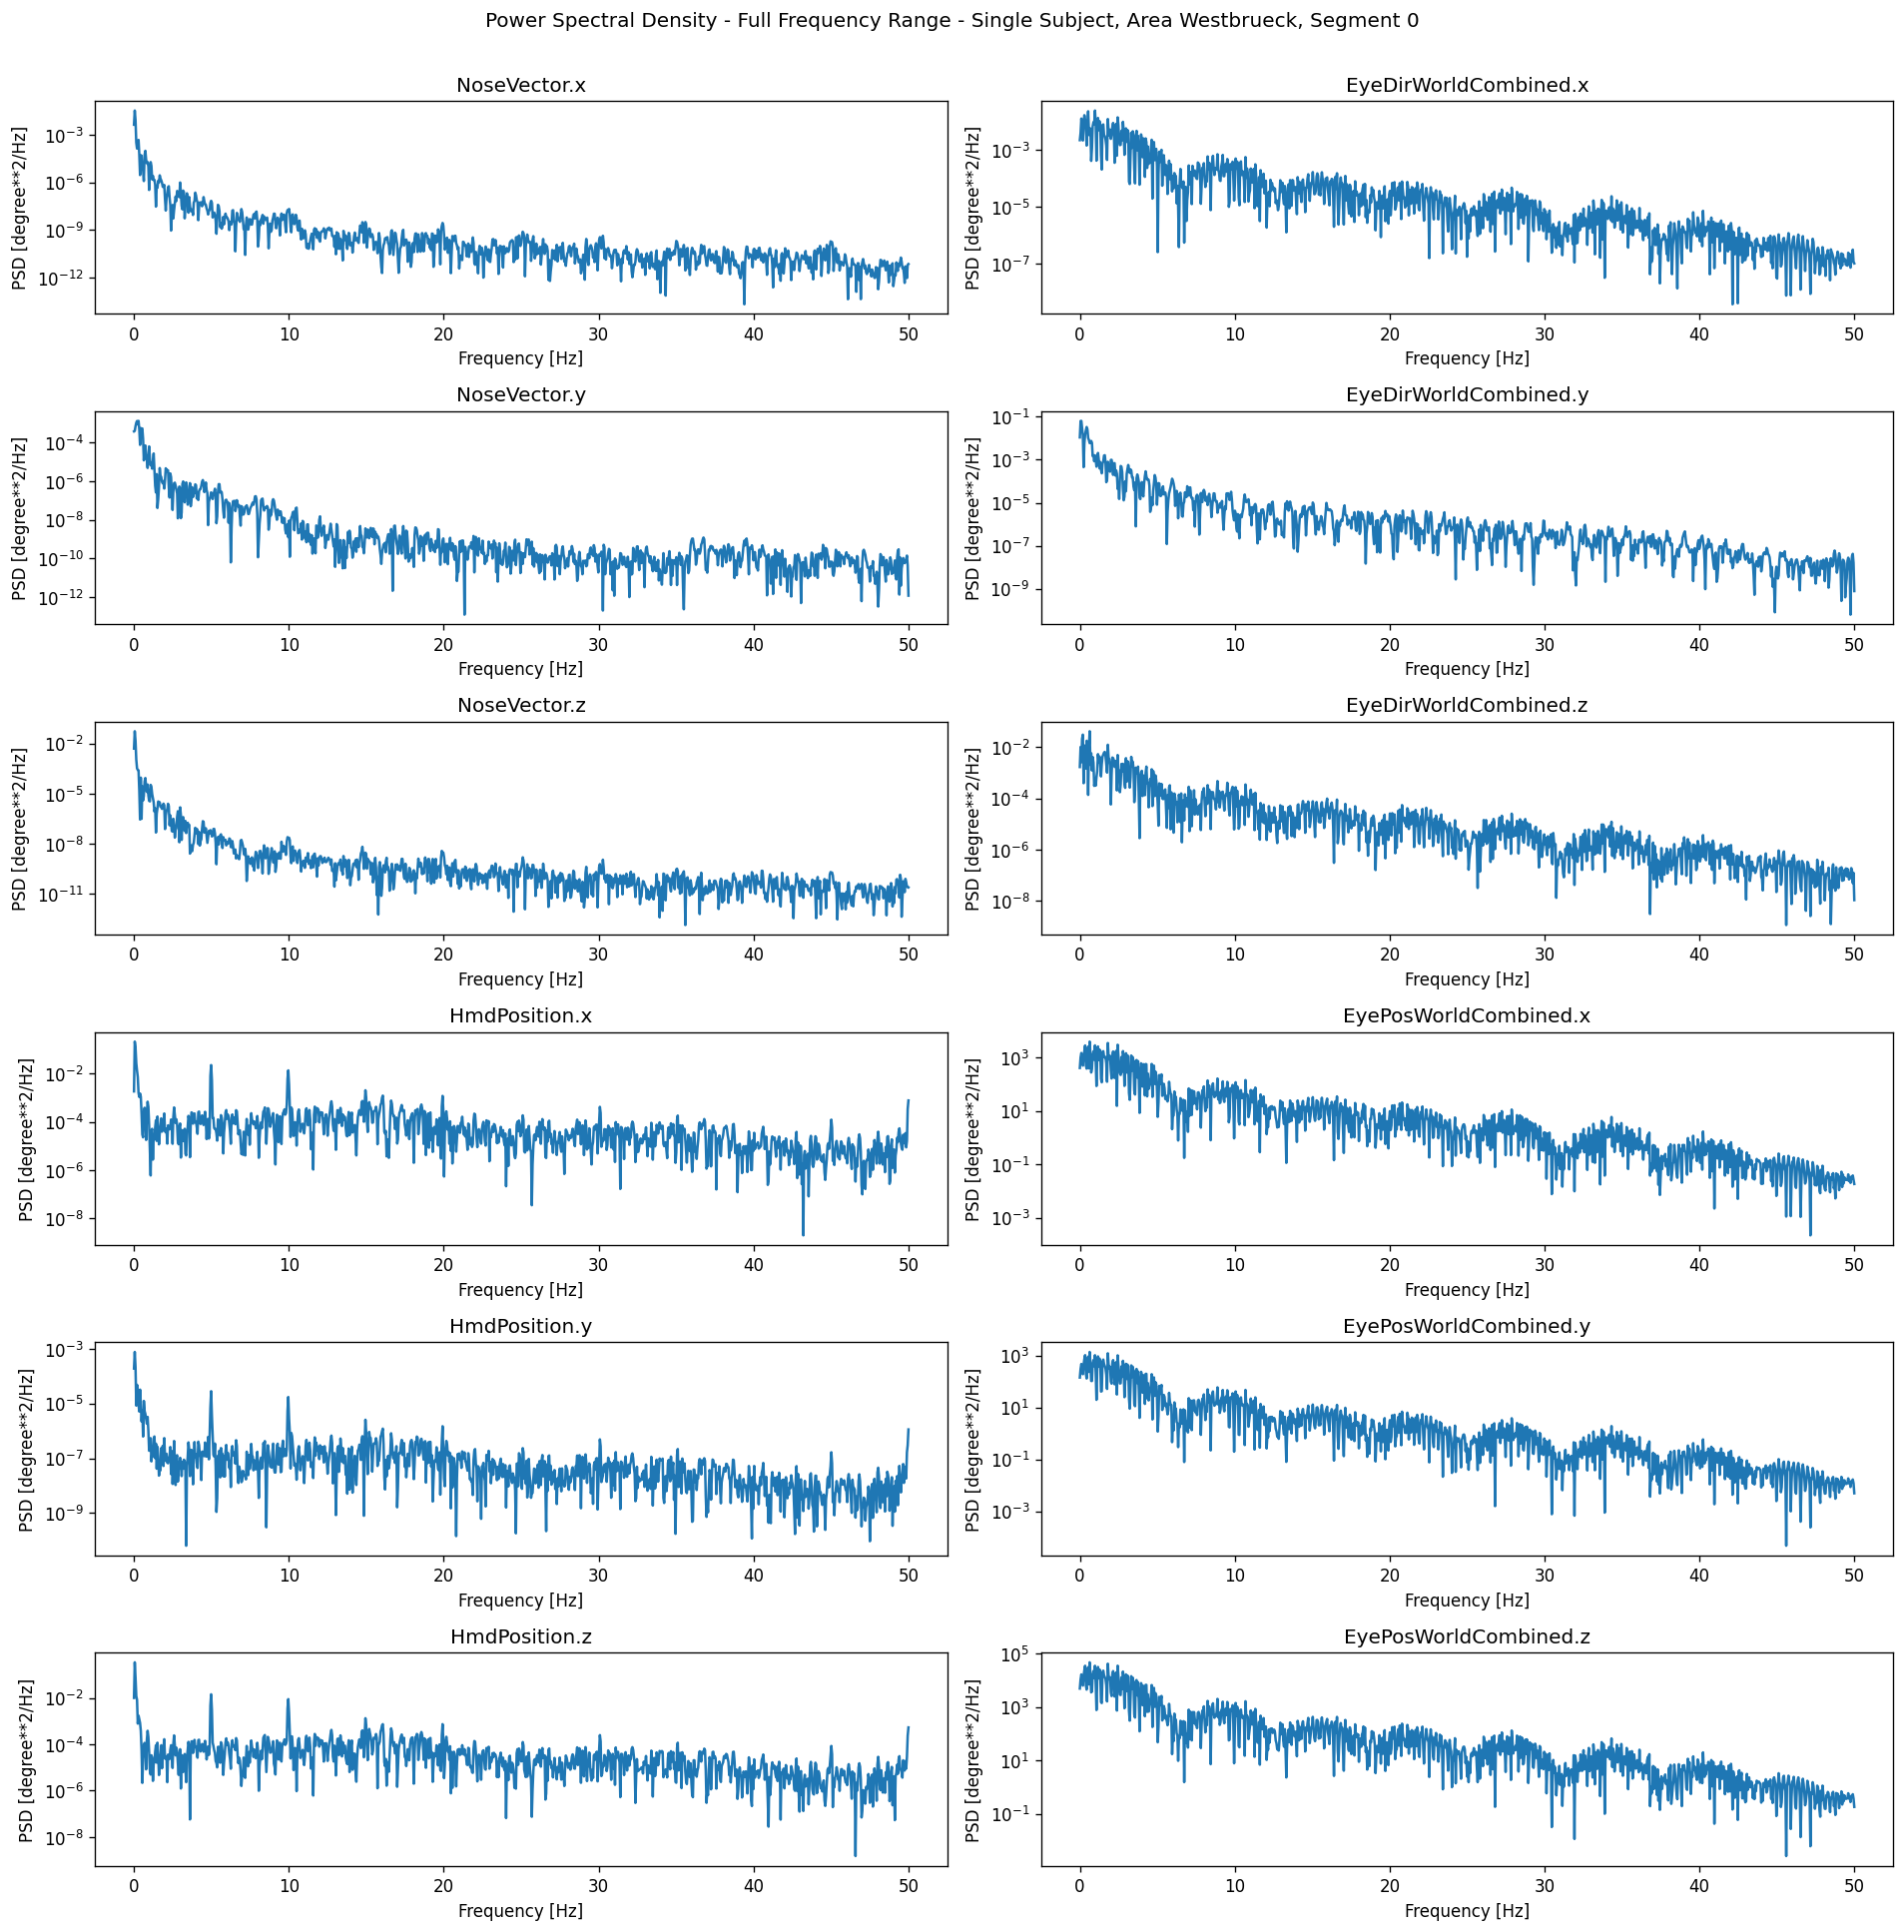

In [15]:
# Power Spectral Density - Full Frequency Range - Single Subject 

names_x = ["NoseVector.x","EyeDirWorldCombined.x","NoseVector.y","EyeDirWorldCombined.y","NoseVector.z","EyeDirWorldCombined.z", \
          "HmdPosition.x","EyePosWorldCombined.x","HmdPosition.y","EyePosWorldCombined.y","HmdPosition.z","EyePosWorldCombined.z"]
segment_data = one_participant_single_segment
plt_title = "Power Spectral Density - Full Frequency Range - Single Subject, Area " + GLOBAL_AREA + ", Segment " + str(GLOBAL_SEGMENT)
fig_size = (16,16)
nrows = 6
ncols = 2
x_lim = -1
y_lim = -1
plot_power_spectral_densities(segment_data,names_x,plt_title,fig_size,nrows,ncols,x_lim,y_lim)


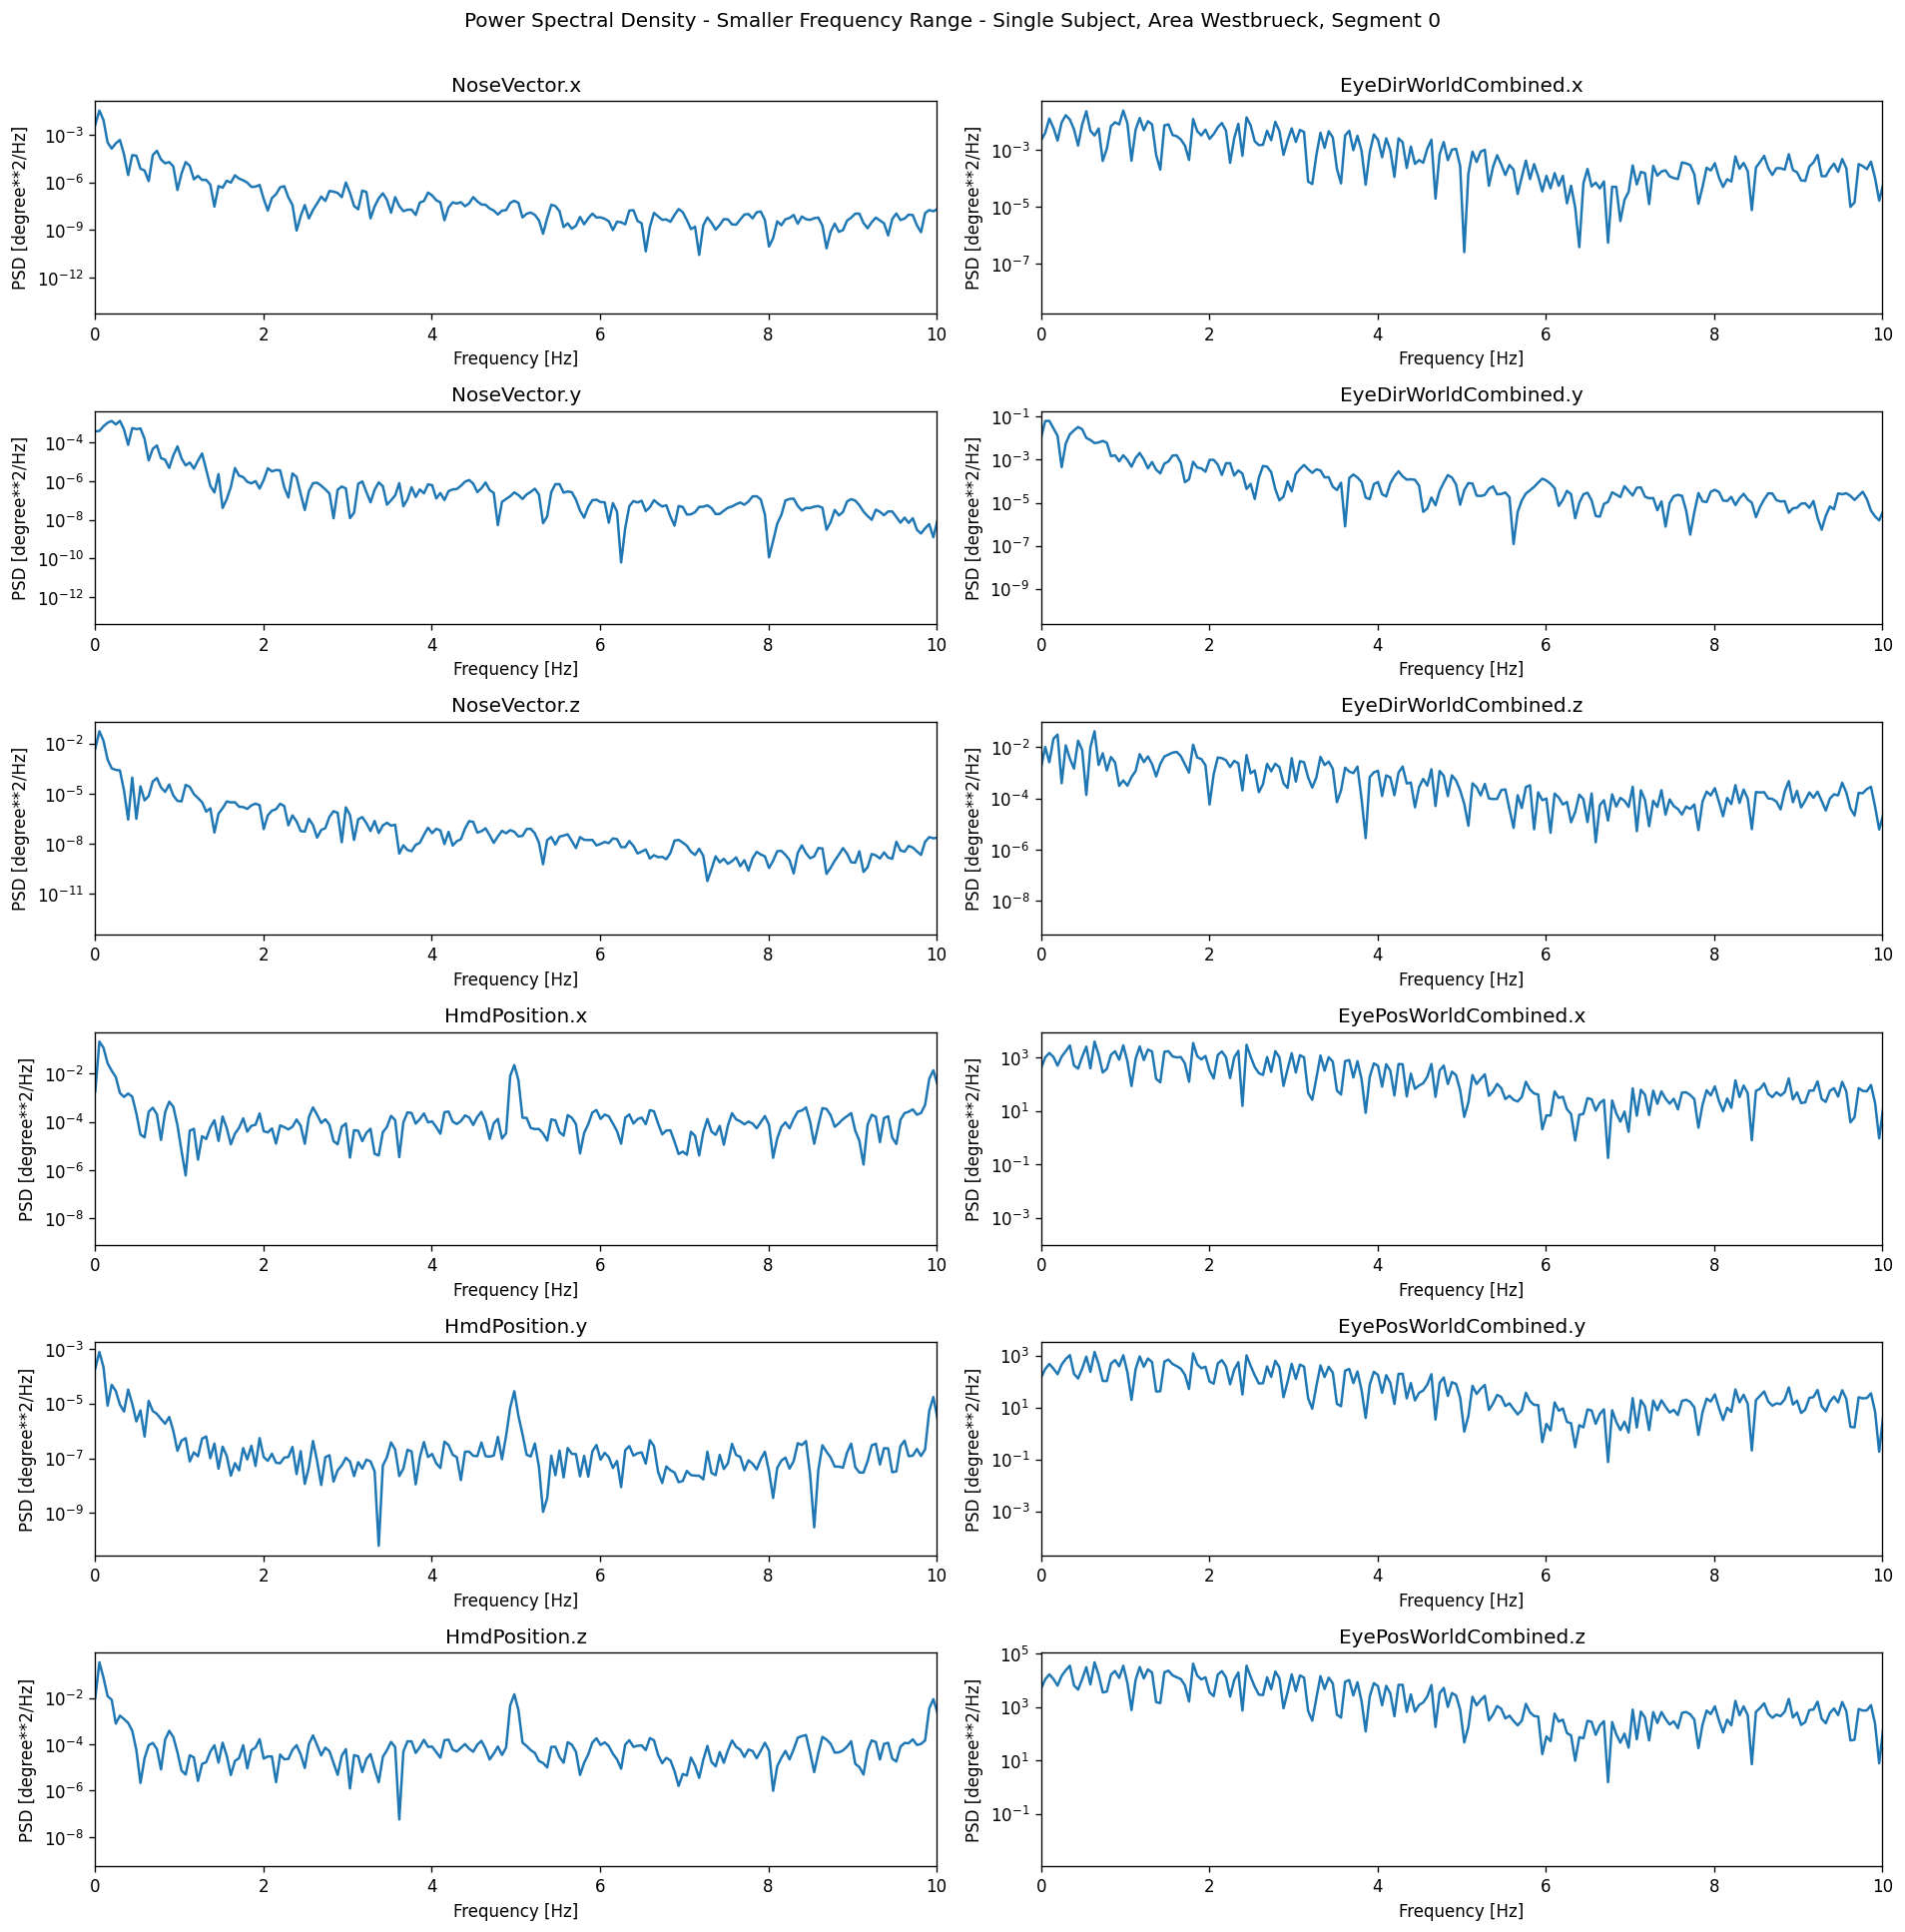

In [16]:
# Power Spectral Density - Smaller Frequency Range - Single Subject

names_x = ["NoseVector.x","EyeDirWorldCombined.x","NoseVector.y","EyeDirWorldCombined.y","NoseVector.z","EyeDirWorldCombined.z", \
          "HmdPosition.x","EyePosWorldCombined.x","HmdPosition.y","EyePosWorldCombined.y","HmdPosition.z","EyePosWorldCombined.z"]
segment_data = one_participant_single_segment
plt_title = "Power Spectral Density - Smaller Frequency Range - Single Subject, Area " + GLOBAL_AREA + ", Segment " + str(GLOBAL_SEGMENT)
fig_size = (16,16)
nrows = 6
ncols = 2
x_lim = 10
y_lim = -1
plot_power_spectral_densities(segment_data,names_x,plt_title,fig_size,nrows,ncols,x_lim,y_lim)


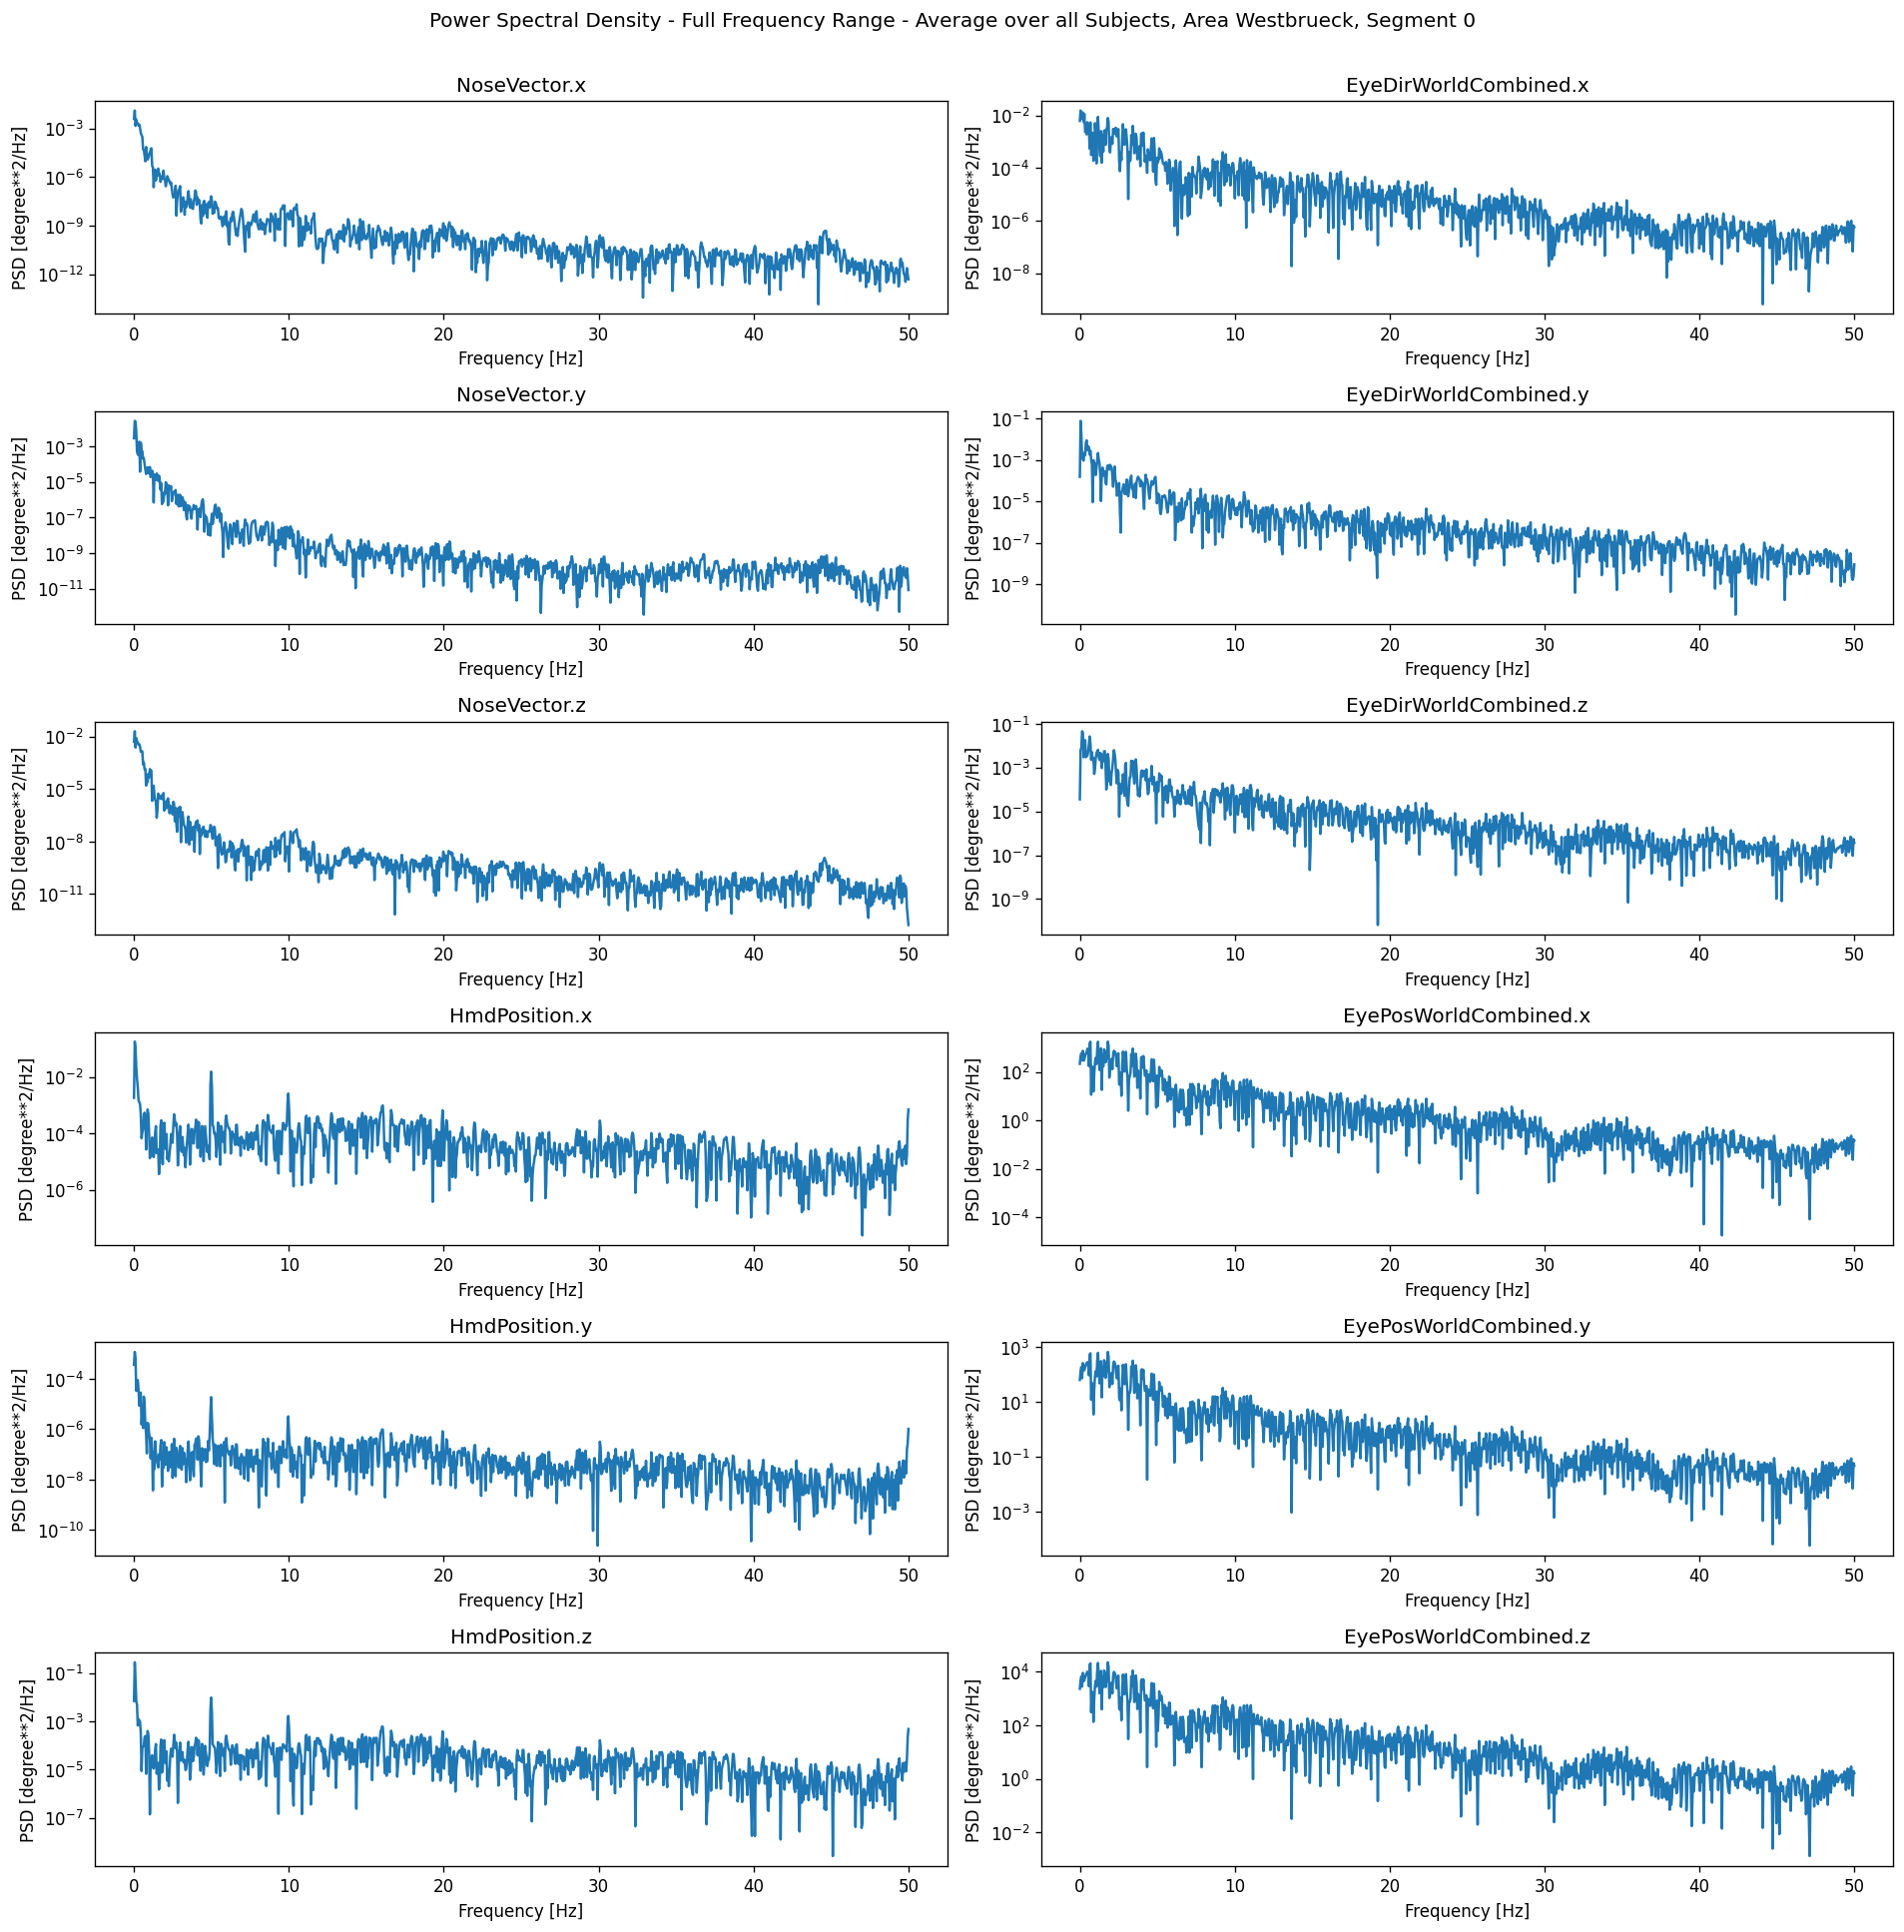

In [17]:
# Power Spectral Density - Full Frequency Range - Average over all Subjects

names_x = ["NoseVector.x","EyeDirWorldCombined.x","NoseVector.y","EyeDirWorldCombined.y","NoseVector.z","EyeDirWorldCombined.z", \
          "HmdPosition.x","EyePosWorldCombined.x","HmdPosition.y","EyePosWorldCombined.y","HmdPosition.z","EyePosWorldCombined.z"]
segment_data = average_over_all_participants_single_segment
plt_title = "Power Spectral Density - Full Frequency Range - Average over all Subjects, Area " + GLOBAL_AREA + ", Segment " + str(GLOBAL_SEGMENT)
fig_size = (16,16)
nrows = 6
ncols = 2
x_lim = -1
y_lim = -1
plot_power_spectral_densities(segment_data,names_x,plt_title,fig_size,nrows,ncols,x_lim,y_lim)



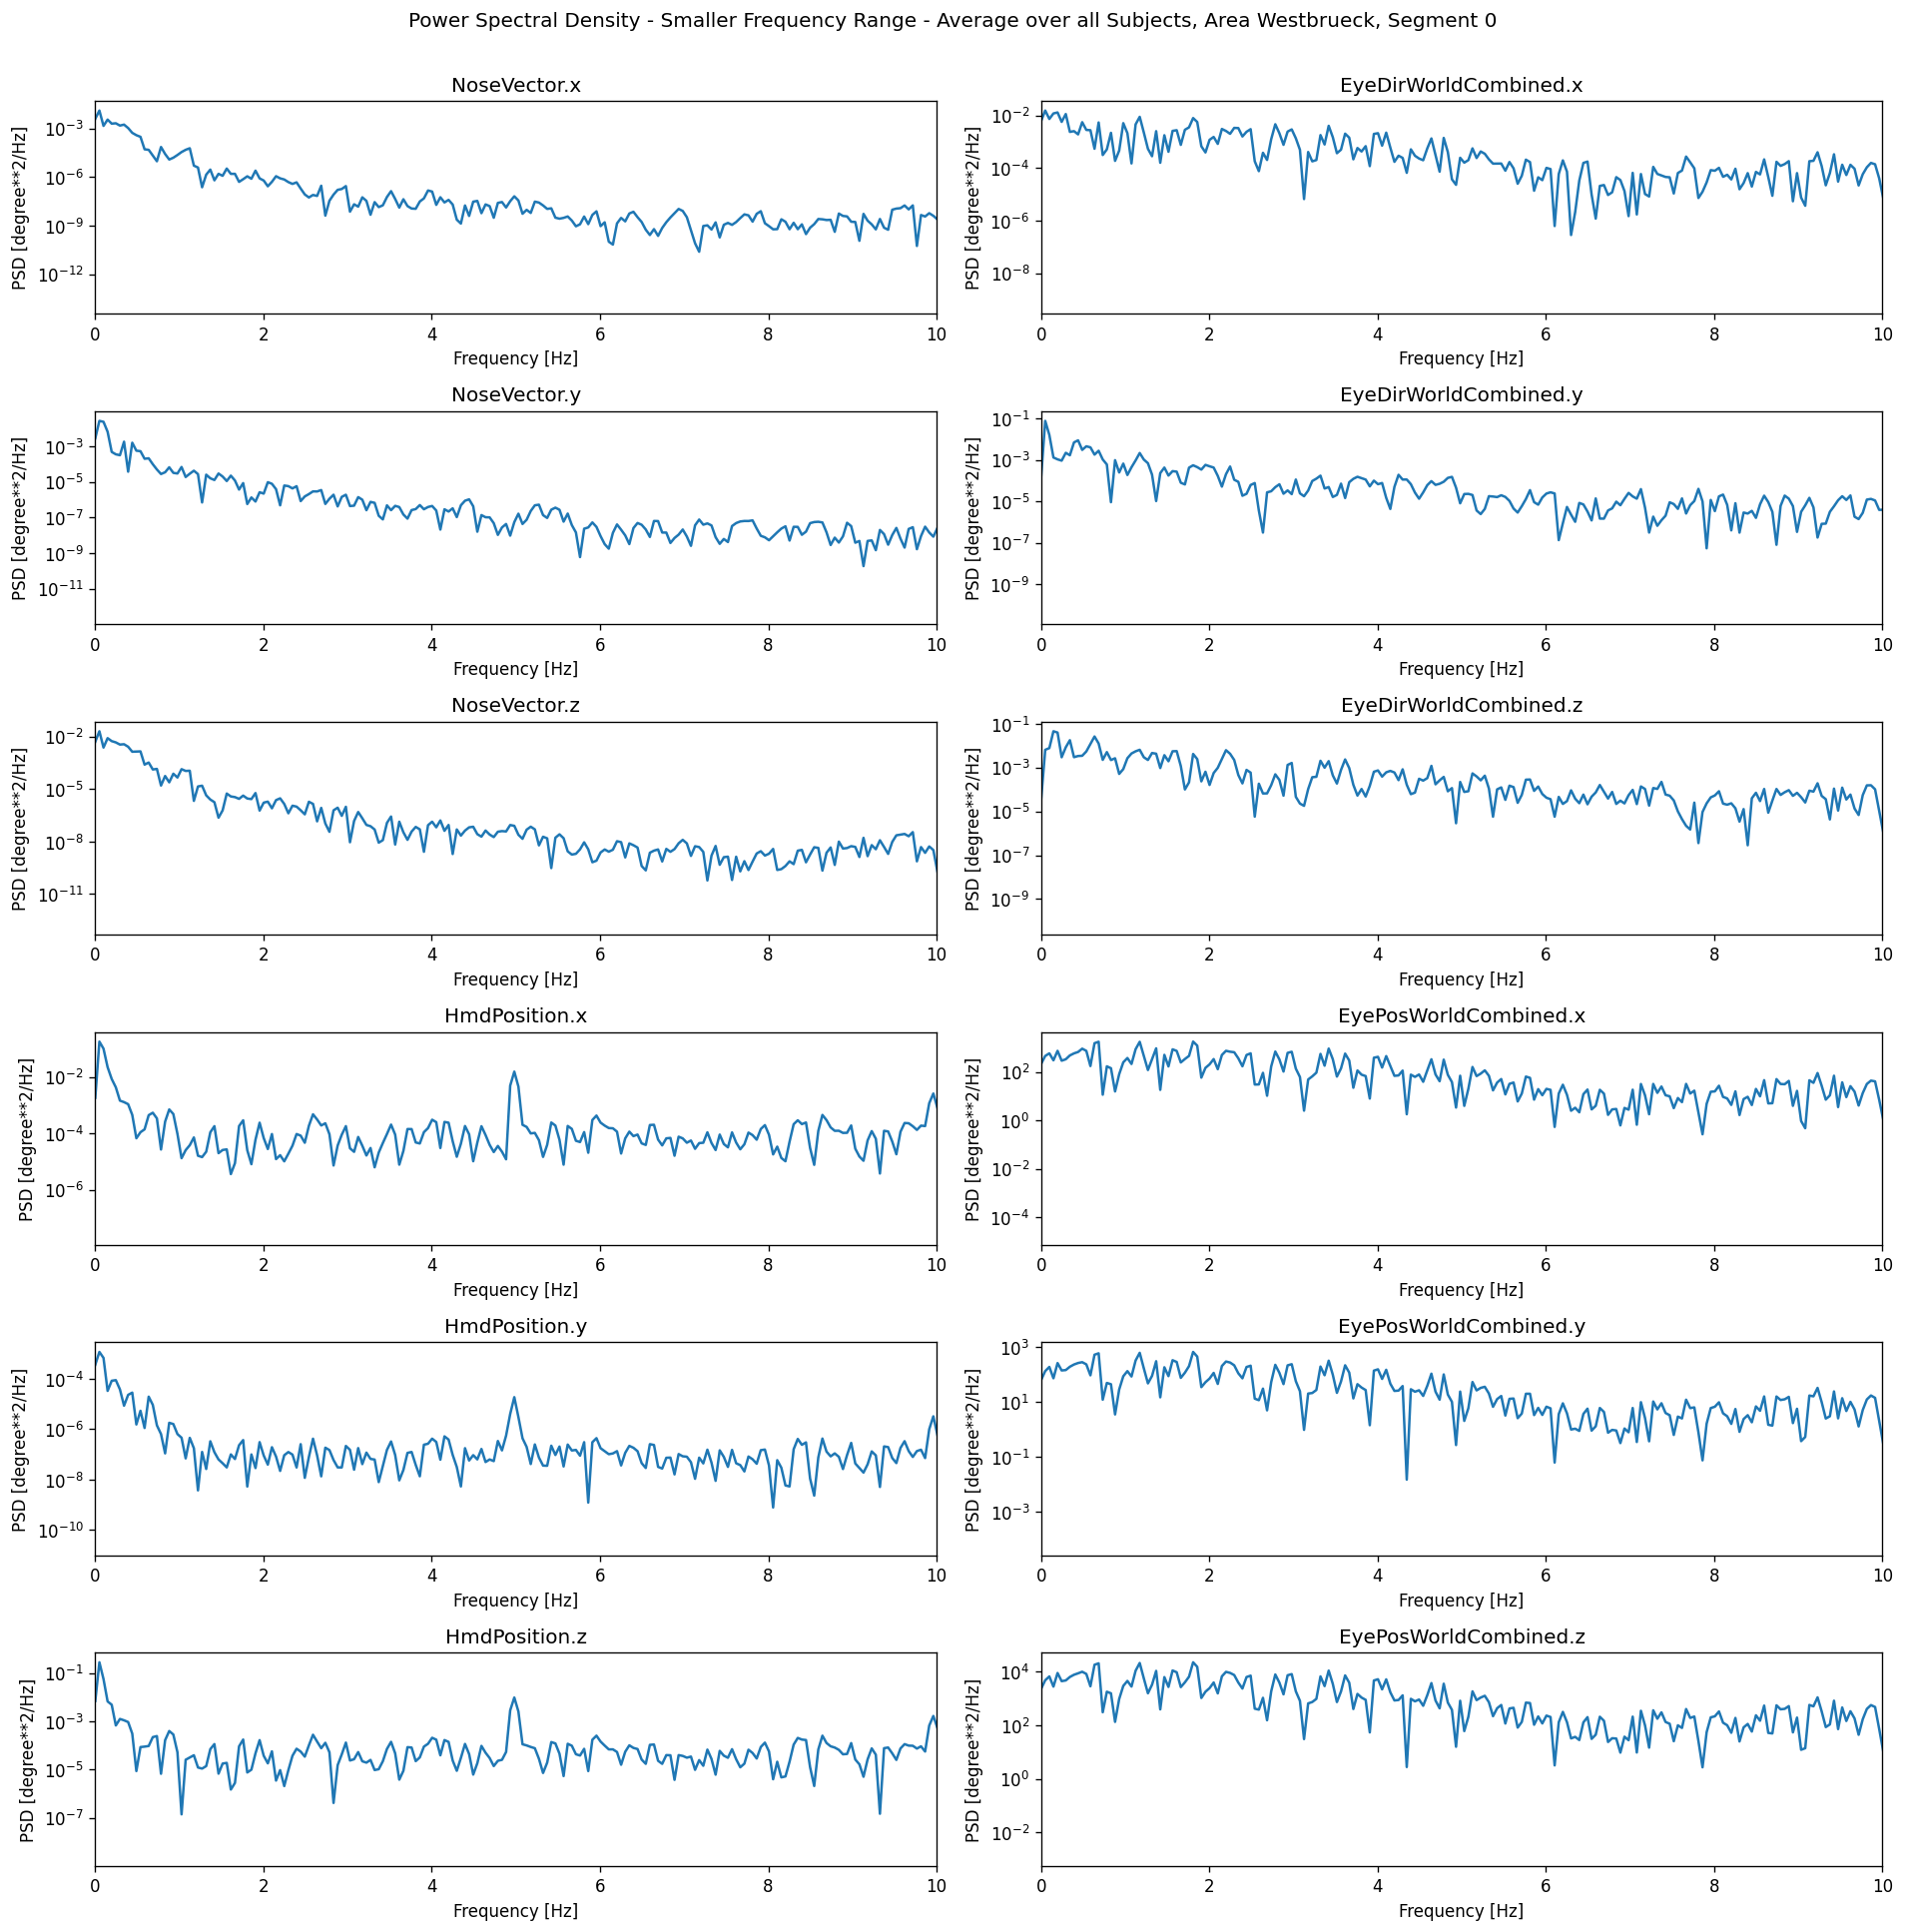

In [18]:
# Power Spectral Density - Smaller Frequency Range - Average over all Subjects

names_x = ["NoseVector.x","EyeDirWorldCombined.x","NoseVector.y","EyeDirWorldCombined.y","NoseVector.z","EyeDirWorldCombined.z", \
          "HmdPosition.x","EyePosWorldCombined.x","HmdPosition.y","EyePosWorldCombined.y","HmdPosition.z","EyePosWorldCombined.z"]
segment_data = average_over_all_participants_single_segment
plt_title = "Power Spectral Density - Smaller Frequency Range - Average over all Subjects, Area " + GLOBAL_AREA + ", Segment " + str(GLOBAL_SEGMENT)
fig_size = (16,16)
nrows = 6
ncols = 2
x_lim = 10
y_lim = -1
plot_power_spectral_densities(segment_data,names_x,plt_title,fig_size,nrows,ncols,x_lim,y_lim)



# Cross spectral density

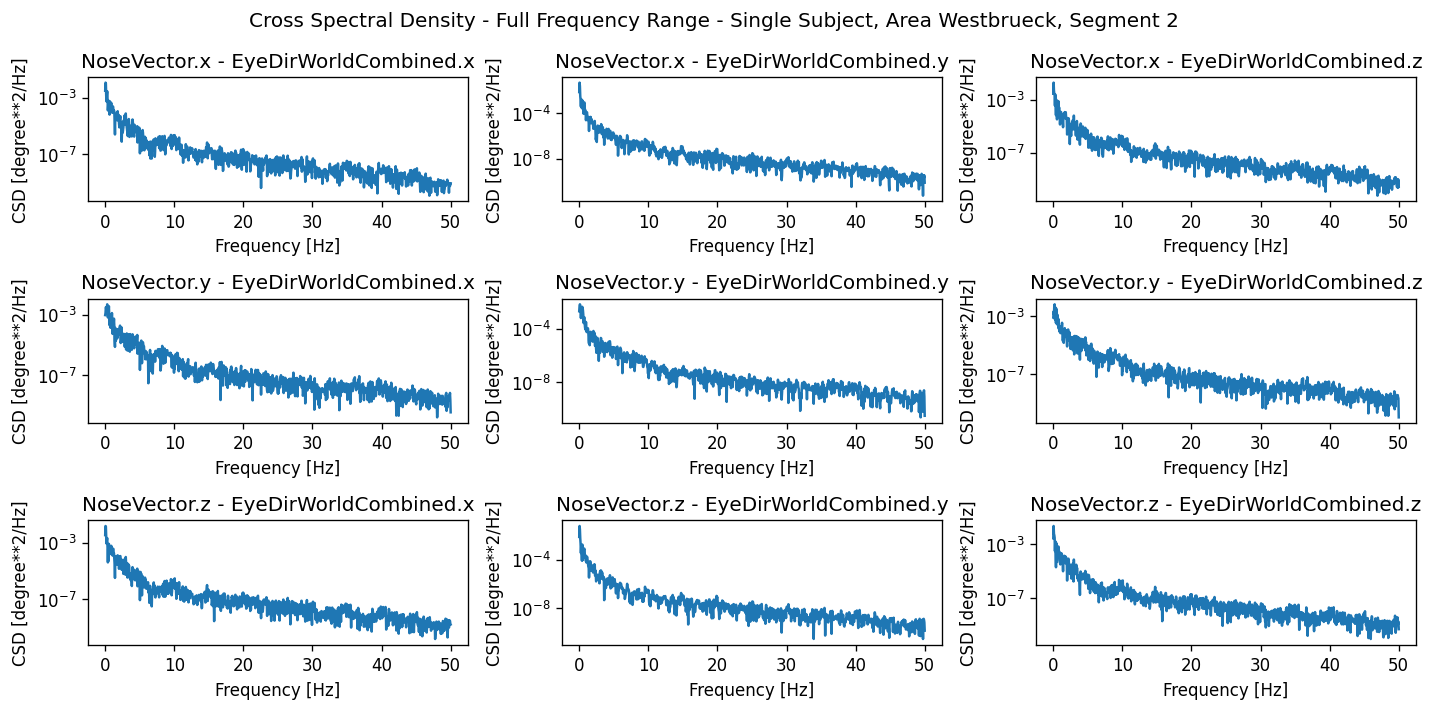

In [19]:
# csd full frequency range 

fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(12,6), dpi=120)

names_x = ["NoseVector.x","NoseVector.x","NoseVector.x","NoseVector.y","NoseVector.y","NoseVector.y","NoseVector.z","NoseVector.z","NoseVector.z"]
names_y = ["EyeDirWorldCombined.x","EyeDirWorldCombined.y","EyeDirWorldCombined.z","EyeDirWorldCombined.x","EyeDirWorldCombined.y","EyeDirWorldCombined.z","EyeDirWorldCombined.x","EyeDirWorldCombined.y","EyeDirWorldCombined.z"]

for idx, row in enumerate(ax.reshape(-1)):
        x = one_participant_single_segment[names_x[idx]]
        y = one_participant_single_segment[names_y[idx]]
        
        sample_freqs, csd = signal.csd(x,y,fs=(1/0.01),nperseg=2048)
        row.semilogy(sample_freqs, np.abs(csd))
        row.set_xlabel("Frequency [Hz]")
        row.set_ylabel("CSD [degree**2/Hz]")
        row.set_title(names_x[idx] + " - " + names_y[idx])

fig.suptitle("Cross Spectral Density - Full Frequency Range - Single Subject, Area Westbrueck, Segment 2")
fig.tight_layout()

plt.show()

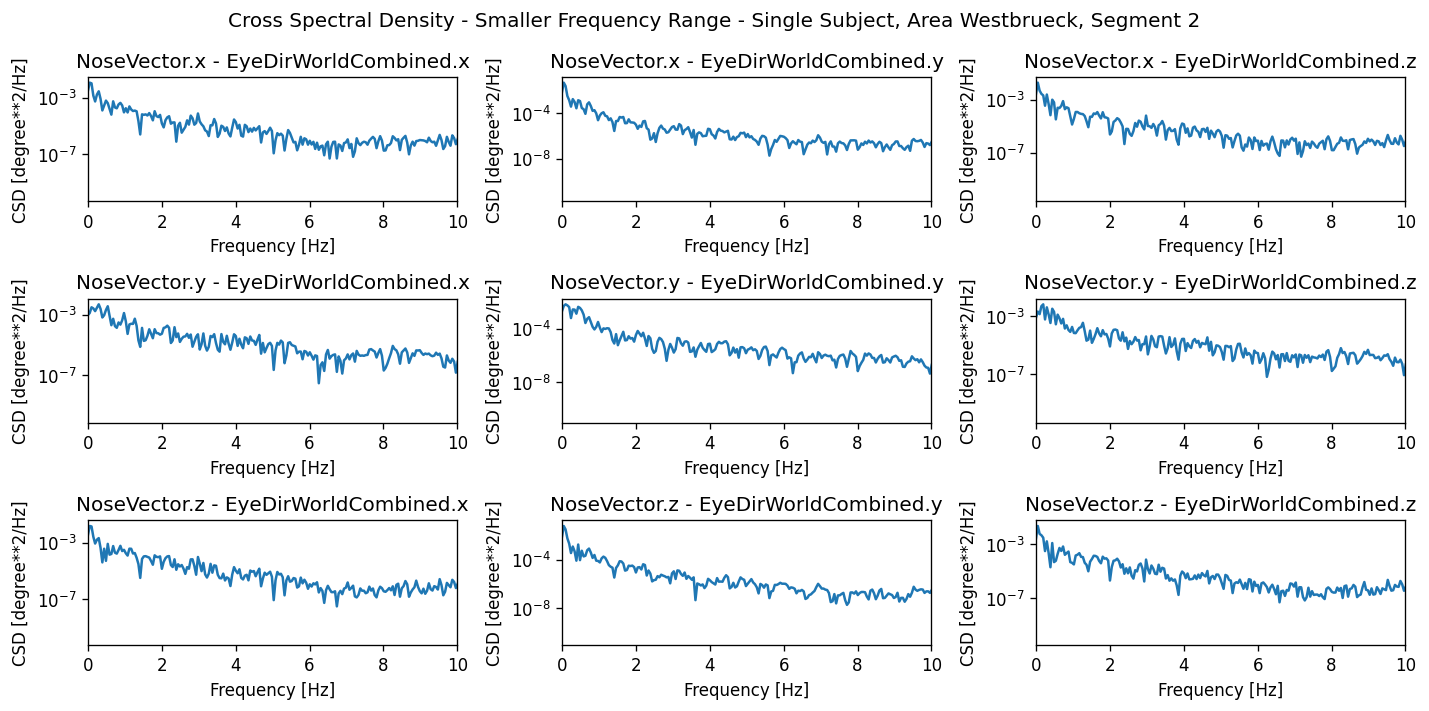

In [20]:
# csd smaller frequency range

fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(12,6), dpi=120)

names_x = ["NoseVector.x","NoseVector.x","NoseVector.x","NoseVector.y","NoseVector.y","NoseVector.y","NoseVector.z","NoseVector.z","NoseVector.z"]
names_y = ["EyeDirWorldCombined.x","EyeDirWorldCombined.y","EyeDirWorldCombined.z","EyeDirWorldCombined.x","EyeDirWorldCombined.y","EyeDirWorldCombined.z","EyeDirWorldCombined.x","EyeDirWorldCombined.y","EyeDirWorldCombined.z"]

for idx, row in enumerate(ax.reshape(-1)):
        x = one_participant_single_segment[names_x[idx]]
        y = one_participant_single_segment[names_y[idx]]
        
        sample_freqs, csd = signal.csd(x,y,fs=(1/0.01),nperseg=2048)
        row.semilogy(sample_freqs, np.abs(csd))
        row.set_xlabel("Frequency [Hz]")
        row.set_ylabel("CSD [degree**2/Hz]")
        row.set_xlim(0,10)
        row.set_title(names_x[idx] + " - " + names_y[idx])

fig.suptitle("Cross Spectral Density - Smaller Frequency Range - Single Subject, Area Westbrueck, Segment 2")
fig.tight_layout()

plt.show()

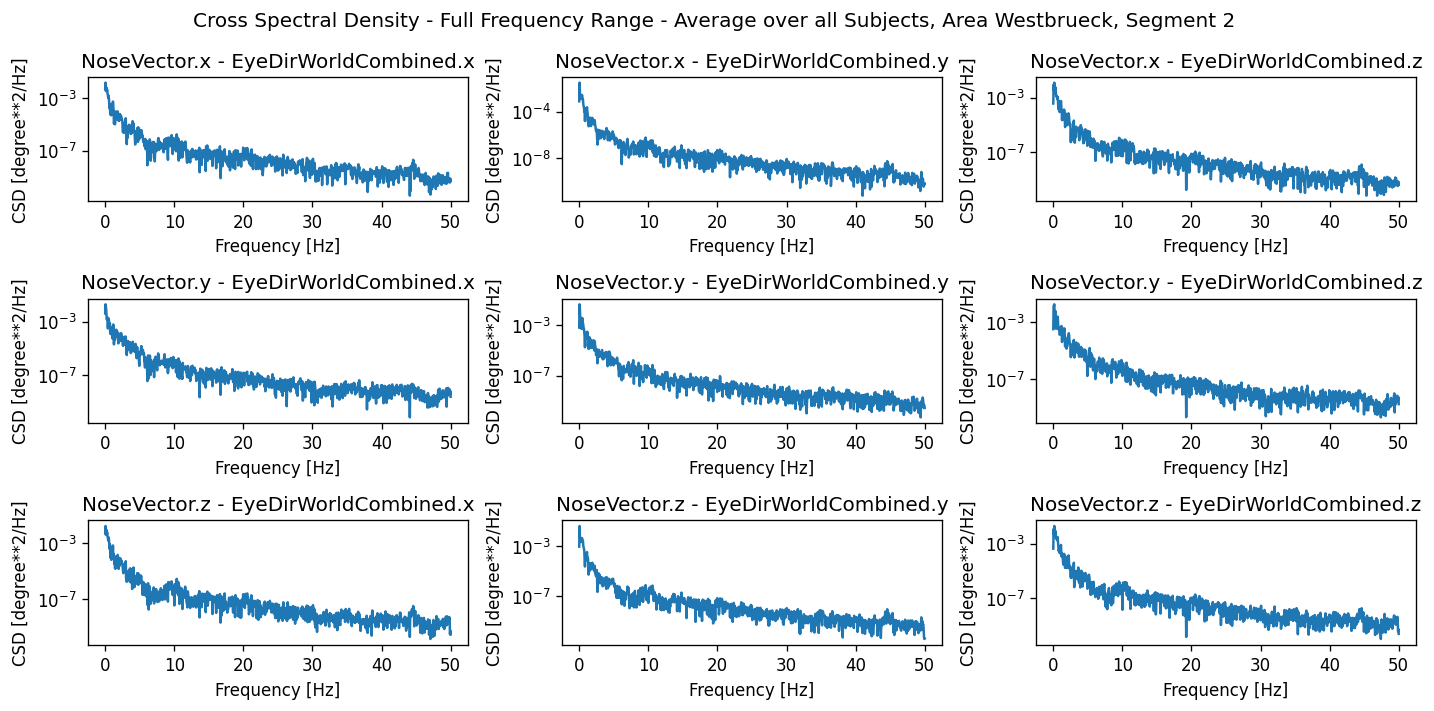

In [21]:
# csd full frequency range 

fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(12,6), dpi=120)

names_x = ["NoseVector.x","NoseVector.x","NoseVector.x","NoseVector.y","NoseVector.y","NoseVector.y","NoseVector.z","NoseVector.z","NoseVector.z"]
names_y = ["EyeDirWorldCombined.x","EyeDirWorldCombined.y","EyeDirWorldCombined.z","EyeDirWorldCombined.x","EyeDirWorldCombined.y","EyeDirWorldCombined.z","EyeDirWorldCombined.x","EyeDirWorldCombined.y","EyeDirWorldCombined.z"]

for idx, row in enumerate(ax.reshape(-1)):
        x = average_over_all_participants_single_segment[names_x[idx]]
        y = average_over_all_participants_single_segment[names_y[idx]]
        
        sample_freqs, csd = signal.csd(x,y,fs=(1/0.01),nperseg=2048)
        row.semilogy(sample_freqs, np.abs(csd))
        row.set_xlabel("Frequency [Hz]")
        row.set_ylabel("CSD [degree**2/Hz]")
        row.set_title(names_x[idx] + " - " + names_y[idx])

fig.suptitle("Cross Spectral Density - Full Frequency Range - Average over all Subjects, Area Westbrueck, Segment 2")
fig.tight_layout()

plt.show()

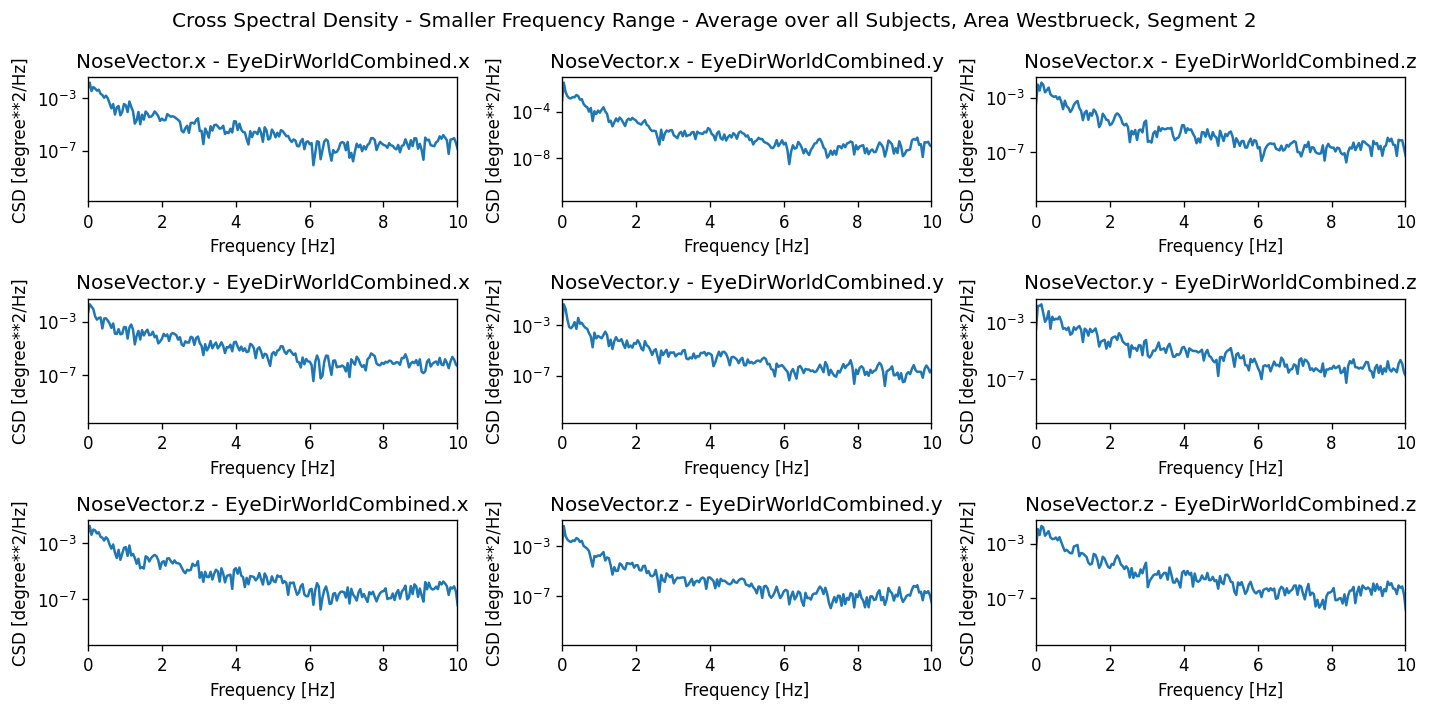

In [22]:
# csd smaller frequency range

fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(12,6), dpi=120)

names_x = ["NoseVector.x","NoseVector.x","NoseVector.x","NoseVector.y","NoseVector.y","NoseVector.y","NoseVector.z","NoseVector.z","NoseVector.z"]
names_y = ["EyeDirWorldCombined.x","EyeDirWorldCombined.y","EyeDirWorldCombined.z","EyeDirWorldCombined.x","EyeDirWorldCombined.y","EyeDirWorldCombined.z","EyeDirWorldCombined.x","EyeDirWorldCombined.y","EyeDirWorldCombined.z"]

for idx, row in enumerate(ax.reshape(-1)):

        x = average_over_all_participants_single_segment[names_x[idx]]
        y = average_over_all_participants_single_segment[names_y[idx]]

        sample_freqs, csd = signal.csd(x,y,fs=(1/0.01),nperseg=2048)
        row.semilogy(sample_freqs, np.abs(csd))
        row.set_xlabel("Frequency [Hz]")
        row.set_ylabel("CSD [degree**2/Hz]")
        row.set_xlim(0,10)
        row.set_title(names_x[idx] + " - " + names_y[idx])

fig.suptitle("Cross Spectral Density - Smaller Frequency Range - Average over all Subjects, Area Westbrueck, Segment 2")
fig.tight_layout()

plt.show()